# Figure 5
## Comparison of figure generation with and without Declarative interface
Adapted from https://github.com/Unidata/python-training/blob/master/pages/gallery/Declarative_300hPa.ipynb.
As an addendum, we generate the identical figure without Declarative. These code snippets are used to generate Figure 4.

### With Declarative
Here we generate the example figure using MetPy's Declarative plotting interface. We'll first import the libraries shared for both workflows.

In [1]:
import xarray as xr

import metpy.calc as mpcalc

# get_test_data is used for internal MetPy testing and not supported publicly
from metpy.cbook import get_test_data
from metpy.units import units

Read GFS output valid 1200 UTC 31 October 2010, provided as part of MetPy's internal testing data.

In [2]:
data = xr.open_dataset(get_test_data("GFS_test.nc", False)).metpy.parse_cf().squeeze()

dt_string = data["time"].dt.strftime("%Y-%m-%d %T").data

ds = data.metpy.sel(lat=slice(70, 10), lon=slice(360 - 150, 360 - 55))

Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection


In [3]:
ds["wind_speed"] = mpcalc.wind_speed(
    ds["u-component_of_wind_isobaric"], ds["v-component_of_wind_isobaric"]
)

Now let's import the Declarative classes we'll use for the demonstrated workflow.

In [4]:
from metpy.plots import BarbPlot, ContourPlot, FilledContourPlot, MapPanel, PanelContainer

Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection


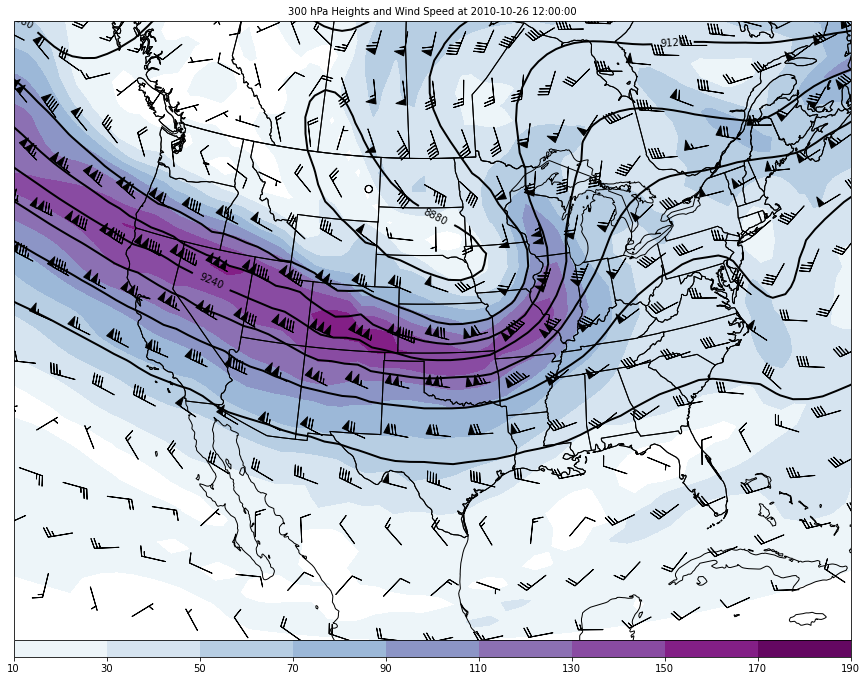

FileNotFoundError: [Errno 2] No such file or directory: 'images/fig5_declarative.png'

In [5]:
contour = ContourPlot()
contour.data = ds
contour.field = "Geopotential_height_isobaric"
contour.level = 300 * units.hPa
contour.contours = list(range(0, 10000, 120))
contour.clabels = True

cfill = FilledContourPlot()
cfill.data = ds
cfill.field = "wind_speed"
cfill.level = 300 * units.hPa
cfill.contours = list(range(10, 201, 20))
cfill.colormap = "BuPu"
cfill.colorbar = "horizontal"
cfill.plot_units = "knot"

barbs = BarbPlot()
barbs.data = ds
barbs.field = ["u-component_of_wind_isobaric", "v-component_of_wind_isobaric"]
barbs.level = 300 * units.hPa
barbs.skip = (3, 3)
barbs.plot_units = "knot"

panel = MapPanel()
panel.area = [-125, -74, 20, 55]
panel.projection = "lcc"
panel.layers = ["states", "coastline", "borders"]
panel.title = f"{cfill.level:~P} Heights and Wind Speed at {dt_string}"
panel.plots = [cfill, contour, barbs]

pc = PanelContainer()
pc.size = (15, 15)
pc.panels = [panel]

pc.save("../images/fig5_declarative.png", dpi=600, bbox_inches="tight")

### Without Declarative
Here, we re-create an identical figure to above, but through "imperative" Matplotlib syntax. We'll now import the separate cartopy and Matplotlib functionality needed.

In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

In [7]:
level = 300 * units.hPa

ds_subset = ds[
    [
        "Geopotential_height_isobaric",
        "wind_speed",
        "u-component_of_wind_isobaric",
        "v-component_of_wind_isobaric",
    ]
].metpy.sel(isobaric3=level)

Text(0.5, 1.0, '300 hPa Heights and Wind Speed at 2010-10-26 12:00:00')

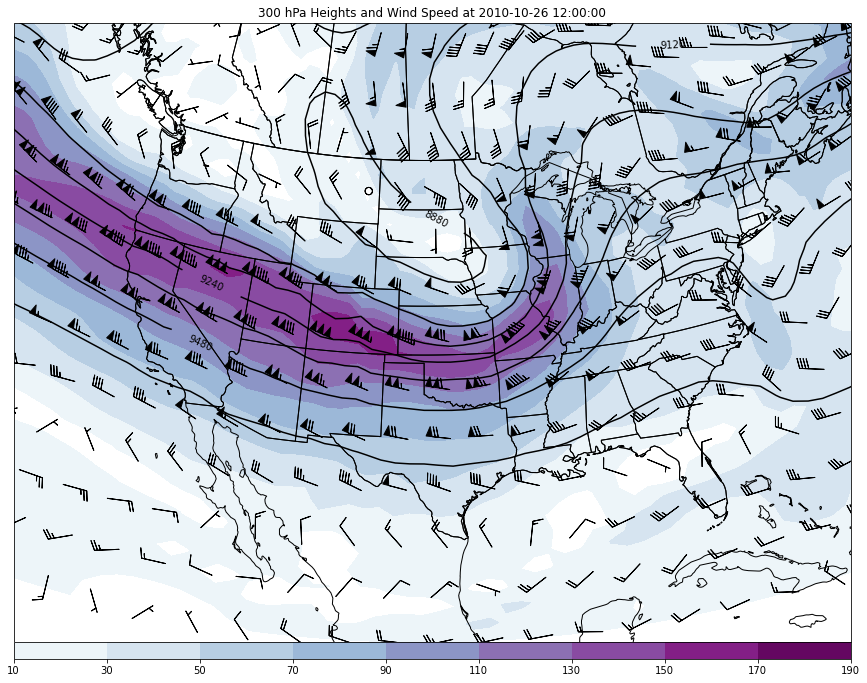

In [8]:
plot_crs = ccrs.LambertConformal(
    central_latitude=40, central_longitude=-100, standard_parallels=[30, 60]
)

data_crs = ds_subset["metpy_crs"].metpy.cartopy_crs

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection=plot_crs)

c = ax.contour(
    ds_subset["lon"],
    ds_subset["lat"],
    ds_subset["Geopotential_height_isobaric"],
    levels=list(range(0, 10000, 120)),
    transform=data_crs,
    colors="k",
)

c.clabel(inline=1, fmt="%.0f", inline_spacing=8, use_clabeltext=True)

cf = ax.contourf(
    ds_subset["lon"],
    ds_subset["lat"],
    ds_subset["wind_speed"].metpy.convert_units("knots"),
    levels=list(range(10, 201, 20)),
    cmap="BuPu",
    transform=data_crs,
)

fig.colorbar(cf, orientation="horizontal", pad=0, aspect=50)

x_slice = slice(None, None, 3)
y_slice = slice(None, None, 3)

ds_subset = ds_subset.sel(lon=x_slice, lat=y_slice)

ax.barbs(
    ds_subset["lon"],
    ds_subset["lat"],
    ds_subset["u-component_of_wind_isobaric"].metpy.convert_units("knots").data,
    ds_subset["v-component_of_wind_isobaric"].metpy.convert_units("knots").data,
    pivot="middle",
    transform=data_crs,
)

ax.set_extent((-125, -74, 20, 55), ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)

ax.set_title(f"{level:~P} Heights and Wind Speed at {dt_string}")